In [51]:
%pylab inline

# Params
BASEDATADIR = "/storage/mgymrek/gtex-estrs/revision/mashr/output-strs/"
BASERESULTSDIR = "/storage/mgymrek/gtex-estrs-paper/revision/results"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
from matplotlib.colors import Colormap

# Import libraries
import os
import pandas as pd
import scipy.stats

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}

lfsr = pd.read_csv(BASEDATADIR + "posterior_lfsr.tsv", sep="\t", index_col=0)
betas = pd.read_csv(BASEDATADIR + "posterior_betas.tsv", sep="\t", index_col=0)
beta_ses = pd.read_csv(BASEDATADIR + "posterior_beta_ses.tsv", sep="\t", index_col=0)
ntissues = len(lfsr.columns)

SAVEPLOT = True
PREFIX = "eSTR-calling"
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

Populating the interactive namespace from numpy and matplotlib


In [7]:
# MashR heatmaps
sharing_thresh = 2

#order same as (subset of) fig2a https://www.nature.com/articles/nature24277.pdf
ORDER = [ \
    'Brain-Caudate',
    'Brain-Cerebellum',
    'WholeBlood',
    'Cells-Transformedfibroblasts',
    'Muscle-Skeletal',
    'Heart-LeftVentricle',
    'Esophagus-Mucosa',
    'Skin-NotSunExposed',
    'Skin-SunExposed',
    'Thyroid',
    'Esophagus-Muscularis',
    'Artery-Aorta',
    'Artery-Tibial',
    'Lung',
    'Nerve-Tibial',     
    'Adipose-Subcutaneous',
    'Adipose-Visceral'
]

#for i in range(len(ORDER)):
#    ORDER[i] = ORDER[i].replace("-", ".")
o_ses = beta_ses.loc[:, ORDER]
o_betas = betas.loc[:, ORDER]
o_zscores = betas/beta_ses

z_thresh = 3
sharing_thresh = 2

# Of effects sig in at least one, how many shared within factor of 2
shareMatrix = np.full((ntissues, ntissues), np.nan)
# Correlation of effect sizes
corrMatrix = np.full((ntissues, ntissues), np.nan)

for tissue1 in np.arange(ntissues):
    for tissue2 in np.arange(tissue1+1):
        significant = (o_zscores.iloc[:, tissue1] >=z_thresh) | (o_zscores.iloc[:, tissue2] >=z_thresh)
        sharedEffects = abs(np.log2(o_betas.iloc[:, tissue1]/o_betas.iloc[:, tissue2])) < 1
        shareMatrix[tissue2, tissue1] = np.sum(sharedEffects & significant)/np.sum(significant)
        shareMatrix[tissue1, tissue2] = np.sum(sharedEffects & significant)/np.sum(significant)
        eff1 = o_betas[significant][ORDER[tissue1]]
        eff2 = o_betas[significant][ORDER[tissue2]]
        corrMatrix[tissue2, tissue1] = scipy.stats.spearmanr(eff1, eff2)[0]
        corrMatrix[tissue1, tissue2] = scipy.stats.spearmanr(eff1, eff2)[0]

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log2


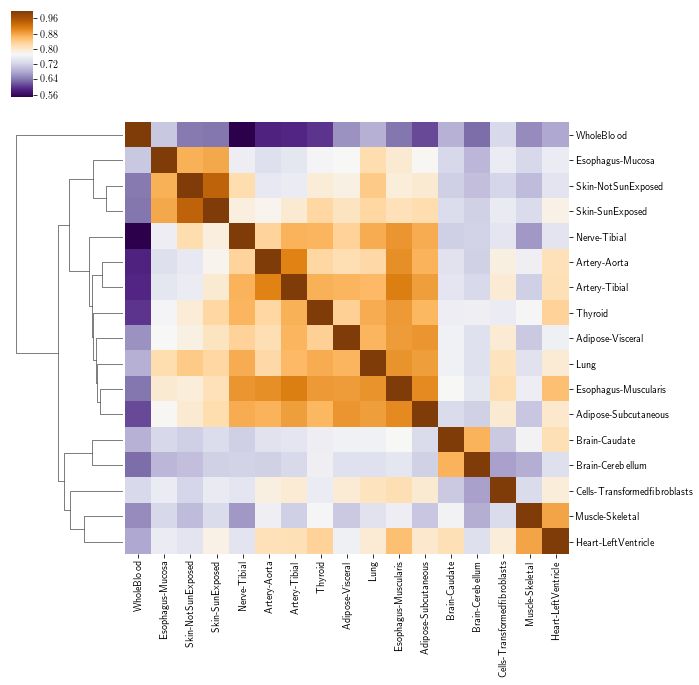

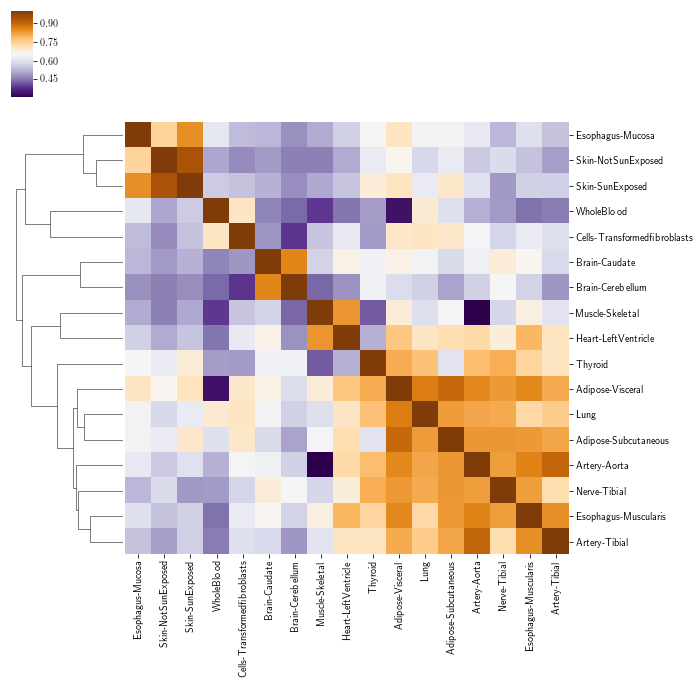

In [54]:
import seaborn as sns

shareMatrix = pd.DataFrame(shareMatrix, columns=ORDER, index=ORDER)
cg = sns.clustermap(shareMatrix, cmap="PuOr_r")
cg.ax_col_dendrogram.set_visible(False)
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "Figure1_mashRHeatmap.pdf"));
    
corrMatrix = pd.DataFrame(corrMatrix, columns=ORDER, index=ORDER)
cg = sns.clustermap(corrMatrix, cmap="PuOr_r")
cg.ax_col_dendrogram.set_visible(False)

In [61]:
# Tissue sharing
z_thresh = 3

zscores_sig = o_zscores.copy() #pd.read_csv(BASEDATADIR + "zscores-sigonly.tsv", sep="\t", index_col=0)

zscores_sig["num"] = zscores_sig.apply(lambda x: sum(abs(x)>=z_thresh), 1)
zscores_sig = zscores_sig[zscores_sig["num"]>0]
signum = zscores_sig.groupby("num", as_index=False).agg({"WholeBlood":len})
signum.columns = ["num.tissues", "num.estrs"]
signum["perc.estrs"] = signum["num.estrs"]/sum(signum["num.estrs"])

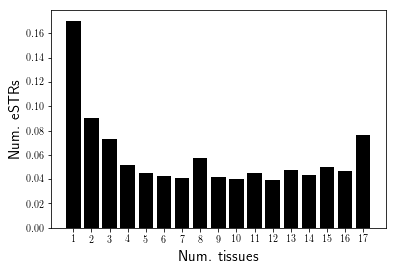

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(signum["num.tissues"], signum["perc.estrs"], color="black");
ax.set_xticks(range(1, len(ORDER)+1));
ax.set_xlabel("Num. tissues", size=15)
ax.set_ylabel("Num. eSTRs", size=15);
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_TissueSharing.pdf"));

In [63]:
zscores_sig[zscores_sig["num"]==1]

,Adipose-Subcutaneous,Adipose-Visceral,Artery-Aorta,Artery-Tibial,Brain-Caudate,Brain-Cerebellum,Cells-Transformedfibroblasts,Esophagus-Mucosa,Esophagus-Muscularis,Heart-LeftVentricle,Lung,Muscle-Skeletal,Nerve-Tibial,Skin-NotSunExposed,Skin-SunExposed,Thyroid,WholeBlood,num
ENSG00000000460.12_chr1_169687928,-1.405999,-1.267005,-0.415068,-0.478390,2.797632,3.095468,-1.537693,-2.510194,-0.198901,1.331073,-1.618444,0.645060,0.415458,-2.436607,-2.497172,0.273364,-1.233254,1
ENSG00000000971.11_chr1_196650601,2.953230,2.664534,2.753630,2.074481,1.975483,1.860289,1.552329,1.780895,2.128182,1.454375,2.619247,1.506325,3.088446,2.121572,2.336021,2.929245,1.572375,1
ENSG00000001461.12_chr1_24722732,-2.211911,-1.532162,-2.553041,-3.743443,0.602255,1.721494,2.064374,-0.170170,-0.088669,0.481844,-1.441238,-2.990273,-1.870812,-1.777121,-1.218657,2.980775,0.863641,1
ENSG00000007341.14_chr1_113095856,2.890172,2.808267,2.169216,2.200469,0.451026,-0.007290,2.786207,3.131145,2.260782,0.968612,2.796109,0.834869,2.002443,2.599284,2.955887,2.141047,2.563383,1
ENSG00000007933.8_chr1_171108164,0.362388,-1.243454,-1.528565,0.591994,0.319113,-0.584052,0.093534,-1.556295,0.927185,0.304849,-0.657868,-2.166373,0.133934,0.576932,-0.119171,-3.006154,-1.489099,1
ENSG00000009790.10_chr1_209910983,2.442952,1.323617,0.974603,1.675699,1.900006,1.145007,1.328019,1.268841,2.439345,1.426631,2.480552,1.553340,1.454046,1.619025,0.921606,2.338071,4.216722,1
ENSG00000009790.10_chr1_209982413,-0.243996,-0.356654,-0.012556,-0.015814,-0.068647,-0.272664,0.135532,0.010350,-0.234734,-0.272049,-0.338538,-0.276882,-0.085982,-0.371417,-0.087723,-0.220087,-4.716683,1
ENSG00000010072.11_chr1_231588126,-2.628731,-2.535385,-2.779823,-2.793112,-1.210682,-0.727953,-2.778879,-2.664433,-2.804490,-1.954409,-3.170875,-1.518369,-2.359441,-2.071296,-2.510179,-2.343091,-2.392585,1
ENSG00000010165.15_chr1_171746069,-0.106122,0.091524,-0.790921,-0.011971,0.868445,-1.840375,-0.252446,1.010469,-2.131166,-1.033894,0.298034,-1.100581,0.684129,0.951605,2.861615,-0.326889,-3.158263,1
ENSG00000010165.15_chr1_171768421,-0.203901,0.549554,-1.893596,-1.268245,-0.124903,-2.911308,0.016586,0.104632,-1.519909,-0.341212,-0.440886,-0.620324,-0.040988,1.189490,0.180910,-1.291276,-3.153786,1
